# AI4IA Hackathon Phase 1: présentation du DataSet et exemple.s de prédiction

# Description:

Ce Notebook est mis à disposition des candidats du Challenge AI4IA-1ere Edition et est exclusivement dédié à cet évènement.

Le but de cet exemple classique est d'aider à la compréhension de ce qui est attendu des candidats, d'introduire les outils mis à disposition ainsi que les jeux de données et leur format. 

Les éléments fournis sont les suivants:
- jeu de données d'exemple (./data/DataSet_ex) sous la forme de plusieurs fichiers .csv, chacun correspondant à un signal d'excitation ;
- fichiers de définition des modèles et de leurs interfaces (cf. model_api.py et les exemples my_model1.py / my_model2.py). Note: le fichier de définition des modèles est la principale soumission des candidats: c'est à ce niveau qu'il est demandé d'implémenter l'architecture du modèle, ainsi que les stratégies d'inférence et d'entrainement;
- script générique pour le lancement d'un entraînement sur une instance AWS via sagemaker ou en local (sagemajer_api.py);
- scripts génériques pour l'évaluation des performances du modèle sur une instance AWS via sagemaker ou en local telles que définies pas les évaluateurs (les mêmes critères d'évaluation/métriques seront appliquées durant la phase d'évalutation, en considérant un jeu de données identique pour chaque candidat ainsi qu'une machine/instance AWS identique);
- une classe de test unitaire (cf. test_submission.py) permettant à tout instant de tester si la solution développée (la définition du modèle notamment) est conforme à ce qui est attendu et à ce qui sera mis en oeuvre lors de la phase d'évaluation. 

Note: il est donc indispensable que le modèle soumis par l'équipe candidate valide tous les tests unitaires et présente les caractéristiques nécessaires à l'évaluation de ses performances sur des instances AWS avec un fichier de test csv arbitraire (via calc_metrics_on_sagemaker.py). Il est donc vivement recommandé de s'assurer que le modèle développé présente bien ces caractéristiques.

Author: François Caire \
Maintainer: François Caire \
Email: francois.caire at skf.com 

# Sommaire :
1. [Chargement des Modules](#1-bullet)
2. [Chargement et exploration du DataSet](#2-bullet)
3. [Exemple Rudimentaire d'apprentissage](#3-bullet)
4. [Entraînement sur AWS SageMaker](#4-bullet)
5. [Evaluation de la solution en local et AWS SageMaker](#5-bullet)

# 1. Chargement des Modules <a class="anchor" id="1-bullet"></a>

Ici on importe les modules classiques

In [25]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


On ajoute des paramètres d'affichage et de tracé...

In [26]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] = 2.0

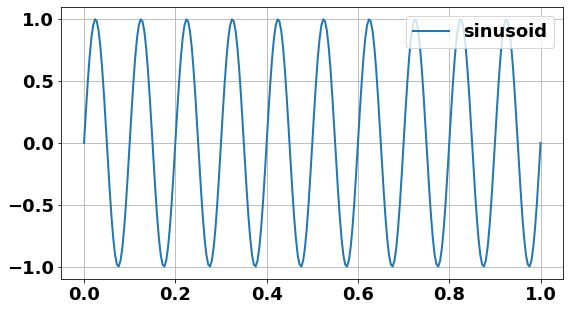

In [27]:
t=np.linspace(0,1,251)
y=np.sin(t*10*2*np.pi)

plt.figure(figsize=(9,5))
plt.plot(t,y,label='sinusoid')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# 2. Chargement et Exploration/Tracé du DataSet d'exemple <a class="anchor" id="2-bullet"></a>

In [28]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(1,6)]

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

In [51]:
for name in names:
    d[name] = d[name][['Time', 'Input', 'Output1', 'Output2', 'Output3', 'Output4', 'Output5']]
d['input3'].head()

,Time,Input,Output1,Output2,Output3,Output4,Output5
0,0.000,0.0,-2.464122e-07,0.5,0.5,1.011923,1.00983
1,0.001,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
2,0.002,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
3,0.003,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983
4,0.004,0.0,-2.464121e-07,0.5,0.5,1.011923,1.00983


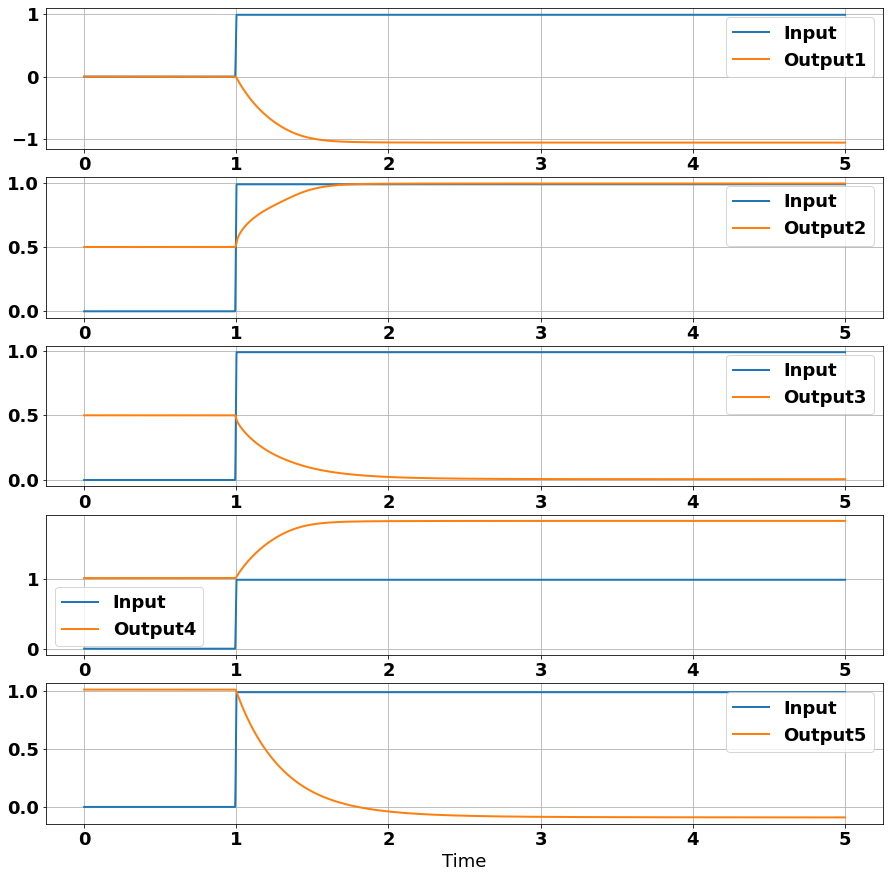

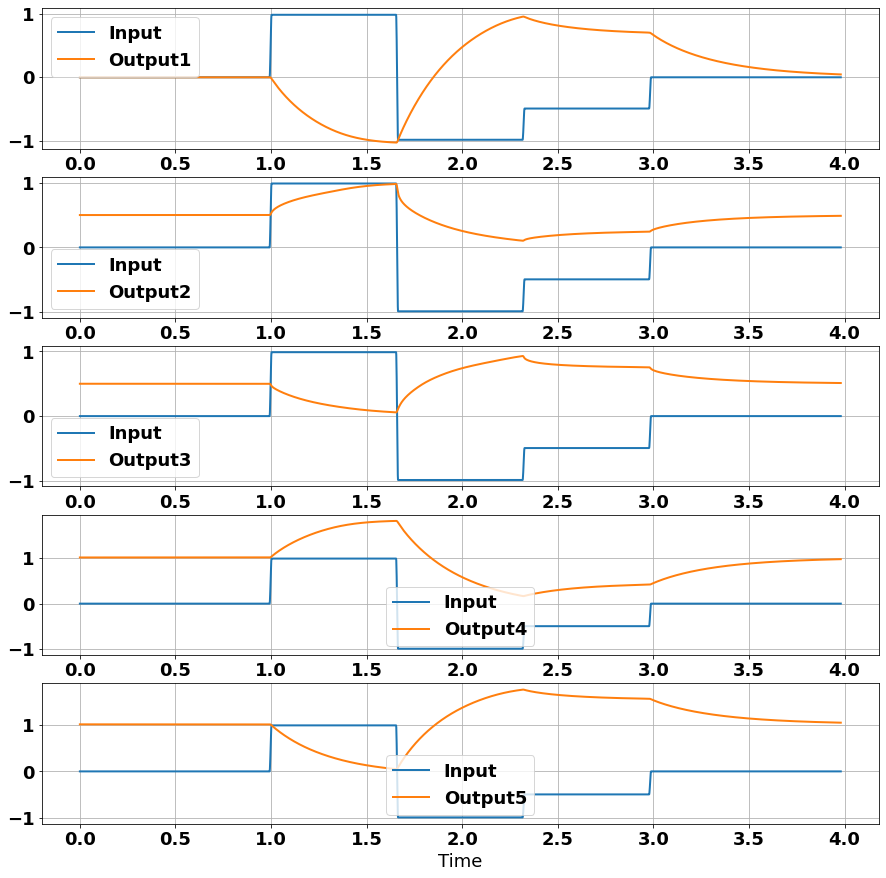

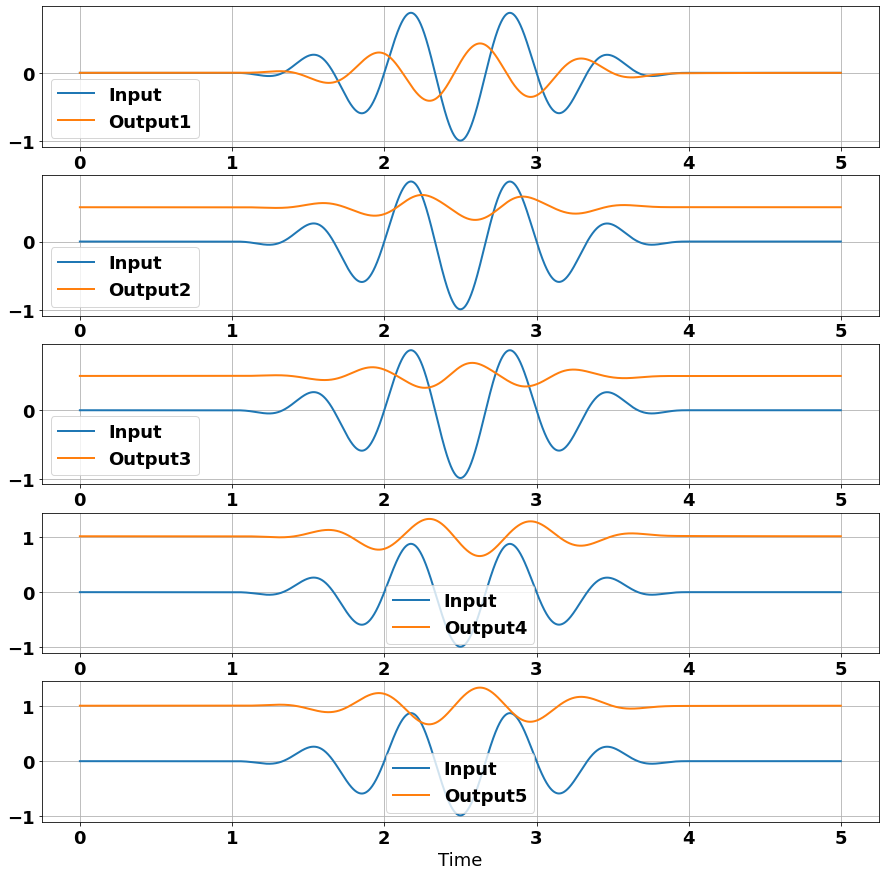

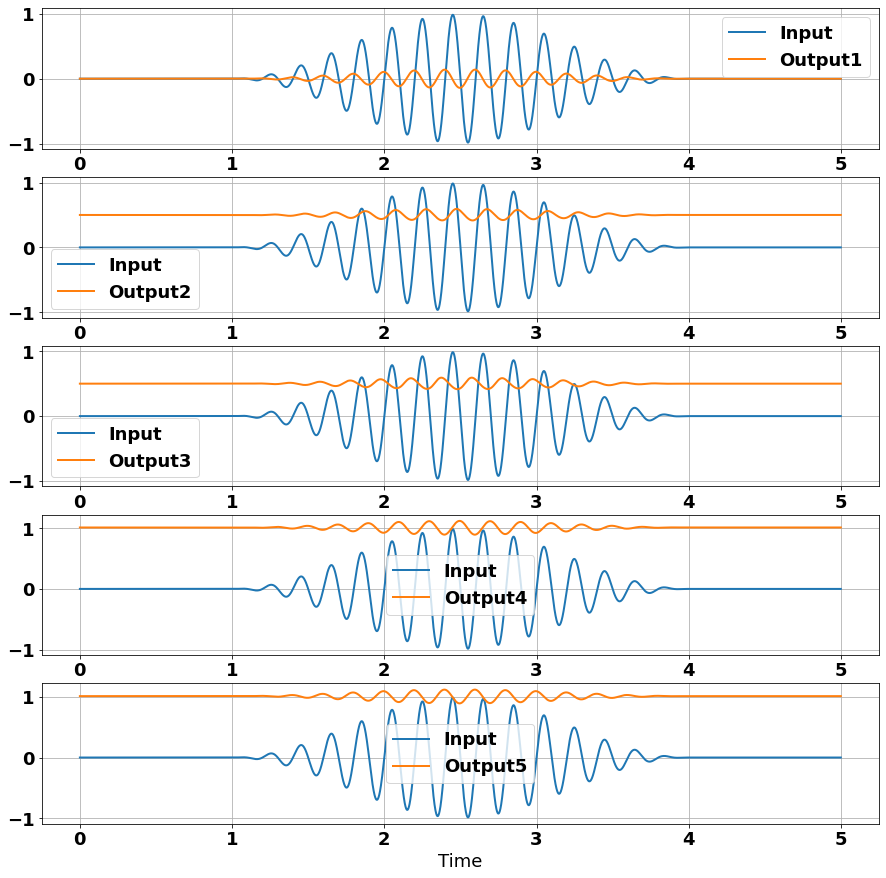

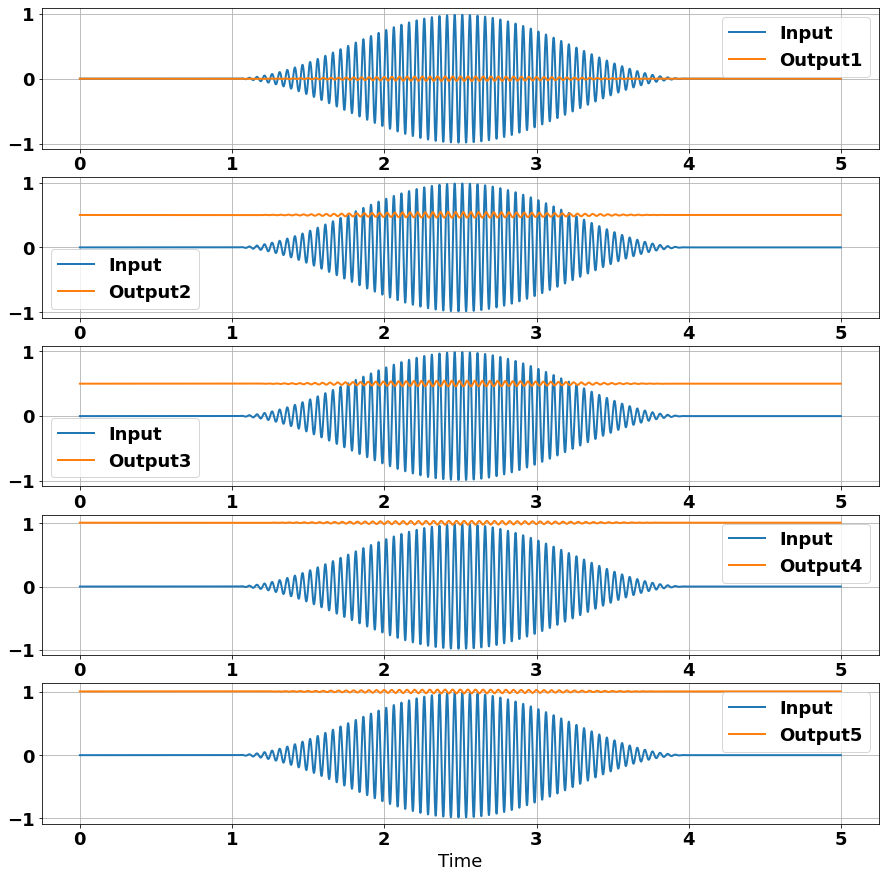

In [52]:
N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')


In [31]:
from sources.utilities.utility_functions import *

t,x,y = load_data_csv("data/DataSet_phase1/input1.csv")

KeyError: 'input'

# 3. Exemple rudimentaire d'apprentissage <a class="anchor" id="3-bullet"></a>

0. Chargement des modules d'intérêt

In [ ]:
import sys
from importlib import reload,import_module
import os

import sagemaker
import boto3

1. On charge ici le modele créé specifiquement

In [ ]:
model_definition = "my_model2"

MyModel = import_module('sources.utilities.' + model_definition).MyModel

On peut vérifier grâce aux tests unitaire que le modele est valide pour soumission (NB: il doit calculer cinq sorties pour les cinq grandeurs d'intérêt)

In [ ]:
!python3 sources/utilities/test_submission.py my_model1
!python3 sources/utilities/test_submission.py my_model2

In [ ]:
!pygmentize "./sources/utilities/my_model2.py"

2. On selectionne le/les signaux utiles pour l'apprentissage et ceux pour la validation:

In [ ]:
rep_data   = "data/DataSet_phase1/"
file_train = "input4.csv"

t_train,x_train,y_train = load_data_csv(rep_data+file_train)

In [ ]:
retrain = True

In [ ]:
if retrain:
    Ndecim=5
    outputs_indexes = [0]
    model = MyModel.create_model(torch.cuda.is_available(), epochs=150, lr=0.05, output_size = len(outputs_indexes))

    model.fit(xs=x_train[::Ndecim], ys=[y_train[k][::Ndecim] for k in outputs_indexes])
    
    retrain = False

y_pred_train = model.predict_timeseries(x_train[::Ndecim])
for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_train[::Ndecim],y_train[outputs_indexes[k]][::Ndecim],'b',t_train[::Ndecim],y_pred_train[k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

In [ ]:
file_test  = "input1.csv"
t_test,x_test,y_test = load_data_csv(rep_data+file_test)

y_pred = model.predict_timeseries(x_test[::Ndecim])

for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_test[::Ndecim],y_test[outputs_indexes[k]][::Ndecim],'b',t_test[::Ndecim],y_pred[k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

# 4. Lancement sur AWS SageMaker <a class="anchor" id="4-bullet"></a>

0. Test local

Permet de vérifier que tout est ok avant de monter l'image sur une instance amazon (ce qui peut être long)

In [ ]:
rep = "data/DataSet_ex/"
file_train = "input4.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName\
                              --model_def_file $model_definition 


In [ ]:
t_train,x_train,y_train = load_data_csv(rep+file_train,Ndecim=Ndecim)
file_test  = "input3.csv"

In [ ]:
model = MyModel.load(model_dir)

In [ ]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[outputs_indexes[k]],'b',t_train,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[outputs_indexes[0]],'b',t_train,y_pred[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])
    
t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)

fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_test,y_test[outputs_indexes[k]],'b',t_test,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[outputs_indexes[0]],'b',t_test,y_test[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


1. Depôt des données sur S3

In [ ]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix_in  = 'DEMO-AI4IA/input'
prefix_out = 'DEMO-AI4IA/model'
role = "arn:aws:iam::<...>:role/service-role/AmazonSageMaker-ExecutionRole-<...>"

In [ ]:
rep_data = './data/DataSet_ex/'

input_channel = sagemaker_session.upload_data(path=rep_data, bucket=bucket, key_prefix=prefix_in)
print('input file (in this case, just an S3 path): {}'.format(input_channel))


2. Creation des instances et paramétrage de l'estimateur:

In [ ]:
output_path = f's3://'+bucket+'/'+prefix_out

outputs_indexes = [0,1,2]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])

In [ ]:
model_name = 'model_GRU'
max_run = 60*60*6 # Max time in seconds

sagemaker_estimator,framework_version = model.get_sagemaker_estimator_class()
estimator = sagemaker_estimator(entry_point = 'sagemaker_api.py',
                                source_dir  = 'sources',
                                role = role,
                                py_version = 'py3',
                                max_run=max_run,
                                framework_version = framework_version,
                                instance_count = 1,
                                instance_type='ml.p3.2xlarge', #'ml.m4.xlarge',#'ml.p2.xlarge',#'ml.p3.2xlarge',#
                                output_path=f's3://'+bucket+'/'+prefix_out,
                                hyperparameters={
                                                    'use_gpu':True,
                                                    'epochs':350000,
                                                    'lr':.05,
                                                    'outputs_indexes': outputs_ind,
                                                    'Ndecim':5,
                                                    'train_fileName':file_train,
                                                    'model_def_file':'my_model2'
                                }
                               )

In [ ]:
estimator.fit({'training': input_channel})

In [ ]:
training_job_name = estimator.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
trained_model_location = desc['ModelArtifacts']['S3ModelArtifacts']
display('Model is here: {}'.format(trained_model_location))

s3 = boto3.resource('s3')    
s3.Bucket(bucket).download_file(os.path.join(prefix_out,desc['TrainingJobName'],'output/model.tar.gz'),'./models/model.tar.gz')

In [ ]:
model_dir = './models/model0'

with tarfile.open('./models/model.tar.gz','r:gz') as archived:
    archived.extractall(model_dir)

In [ ]:
model = MyModel.load(model_dir)

In [ ]:
outputs_indexes

In [ ]:
y_pred = model.predict_timeseries(x_train)

No = len(outputs_indexes)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_train,y_train[outputs_indexes[k]],'b',t_train,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_train,y_train[outputs_indexes[0]],'b',t_train,y_pred[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])

t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)
fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:

    for k in range(No):
        ax[k].plot(t_test,y_test[outputs_indexes[k]],'b',t_test,y_pred[k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[outputs_indexes[0]],'b',t_test,y_test[0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()


In [ ]:
rep = "data/DataSet_ex/"
file_train = "input1.csv"
data = rep + file_train

use_gpu = True
epochs = 40
model_dir = "./models/model1"
model_name = "model0"
lr = 0.05
Ndecim = 5
outputs_indexes = [0,1,2,3,4]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName

# 5. Evaluation des solutions <a class="anchor" id="5-bullet"></a>

0. Recuperation des paramètres (modele et entraînement)

In [ ]:
with open("./models/model1/hyper.json","r") as f:
    dHyper = json.load(f)

with open("models/model1/model_kwargs.json","r") as f:
    dKwargs = json.load(f)

In [ ]:
dHyper,dKwargs

1. Local metric tests

In [ ]:
model1 = MyModel(**dKwargs)

In [ ]:
data_dir = "./data/DataSet_ex"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input2.csv'
model_dir       = './models/model1'
model_def_file  = 'my_model2'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


In [ ]:
with open('./metrics/s2m_GRU2_metrics','r') as f: print(f.read())

2. AWS Metrics tests

In [ ]:
metrics_dir = './metrics_sage'
model_def_file = "my_model1"
type_instance = 'ml.m5.xlarge' # Mention that the time limit is t on this specific type of instance

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

In [ ]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU1' + '_metrics'),'r') as f:  print(f.read())

In [ ]:
metrics_dir = './metrics_sage'
model_def_file = "my_model2"

%run calc_metrics_on_sagemaker.py --data_dir $data_dir \
                                  --model_dir $model_dir \
                                  --role $role \
                                  --estimator_hyperParams_fileName $hyper_fileName \
                                  --model_kwargs_fileName $kwargs_filename \
                                  --test_fileName $test_filename \
                                  --out_dir $metrics_dir \
                                  --model_def_file $model_def_file

In [ ]:
with open(os.path.join(metrics_dir,'s2m' '_' + 'GRU2' + '_metrics'),'r') as f:  print(f.read())

In [ ]:
!pipreqs ./ --force